In [7]:
import tensorflow as tf
from tensorflow.keras.layers import AveragePooling2D, Flatten, Dense, Input, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Establecer los directorios de datos en Kaggle
train_dir = '../input/lungs-disease-dataset-4-types/Lung Disease Dataset/train'
test_dir = '../input/lungs-disease-dataset-4-types/Lung Disease Dataset/test'
val_dir = '../input/lungs-disease-dataset-4-types/Lung Disease Dataset/val'

# Parámetros
lote_size = 20
learning_rate = 0.001
epochs = 10


In [8]:
# Crear generadores de datos
datagen = ImageDataGenerator(rescale=1./255.)
train_generator = datagen.flow_from_directory(
    directory=train_dir,
    target_size=(256, 256),
    batch_size=lote_size,
    shuffle=True,
    class_mode="categorical"
)
test_generator = datagen.flow_from_directory(
    directory=test_dir,
    target_size=(256, 256),
    batch_size=lote_size,
    shuffle=False,
    class_mode="categorical"
)
valid_generator = datagen.flow_from_directory(
    directory=val_dir,
    target_size=(256, 256),
    batch_size=lote_size,
    shuffle=False,
    class_mode="categorical"
)


Found 6054 images belonging to 5 classes.
Found 2025 images belonging to 5 classes.
Found 2016 images belonging to 5 classes.


In [9]:
# Cargar MobileNet pre-entrenado
base_model = tf.keras.applications.MobileNet(weights="/kaggle/input/mobileneth5/mobilenet_1_0_224_tf_no_top.h5",
                                             include_top=False,
                                             input_tensor=Input(shape=(256, 256, 3)))
for layer in base_model.layers:
    layer.trainable = False

# Agregar capas personalizadas
x = base_model.output
x = AveragePooling2D(pool_size=(4, 4))(x)
x = Flatten(name='flatten')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [10]:
# Define una función para programar la tasa de aprendizaje
def lr_schedule(epoch):
    lr = learning_rate
    if epoch > 50:
        lr *= 0.1
    elif epoch > 75:
        lr *= 0.01
    return lr

# Crear un objeto LearningRateScheduler
lr_scheduler = LearningRateScheduler(lr_schedule)

# Definir el optimizador SGD
optimizer = SGD(learning_rate=learning_rate, momentum=0.9)

# Compilar el modelo con el optimizador y el LearningRateScheduler
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])

# Callbacks
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
checkpointer = ModelCheckpoint(filepath="MobileNet_LungDisease.hdf5", verbose=1, save_best_only=True)

In [11]:
# Entrenar el modelo
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // lote_size,
                    epochs=epochs,
                    validation_data=valid_generator,
                    validation_steps=valid_generator.samples // lote_size,
                    callbacks=[checkpointer, earlystopping])

# Guardar el modelo entrenado
model.save("MobileNet_LungDisease.h5")

# Calcular el número de pasos para abarcar todas las imágenes de prueba
num_test_steps = len(test_generator)

# Evaluar el modelo en el conjunto de prueba
test_predict = model.predict(test_generator, steps=num_test_steps, verbose=1)

# Obtener las etiquetas verdaderas
original = []
for i in range(num_test_steps):
    original.extend(test_generator[i][1])

original = np.argmax(original, axis=1)

# Obtener las predicciones
predict = np.argmax(test_predict, axis=1)


Epoch 1/10
302/302 [==============================] - ETA: 0s - loss: 0.6210 - accuracy: 0.7980
Epoch 1: val_loss improved from inf to 0.55679, saving model to MobileNet_LungDisease.hdf5
302/302 [==============================] - 286s 938ms/step - loss: 0.6210 - accuracy: 0.7980 - val_loss: 0.5568 - val_accuracy: 0.7775
Epoch 2/10
302/302 [==============================] - ETA: 0s - loss: 0.3522 - accuracy: 0.8881
Epoch 2: val_loss improved from 0.55679 to 0.50209, saving model to MobileNet_LungDisease.hdf5
302/302 [==============================] - 279s 922ms/step - loss: 0.3522 - accuracy: 0.8881 - val_loss: 0.5021 - val_accuracy: 0.8025
Epoch 3/10
302/302 [==============================] - ETA: 0s - loss: 0.2753 - accuracy: 0.9074
Epoch 3: val_loss improved from 0.50209 to 0.37925, saving model to MobileNet_LungDisease.hdf5
302/302 [==============================] - 281s 929ms/step - loss: 0.2753 - accuracy: 0.9074 - val_loss: 0.3793 - val_accuracy: 0.8535
Epoch 4/10
302/302 [======

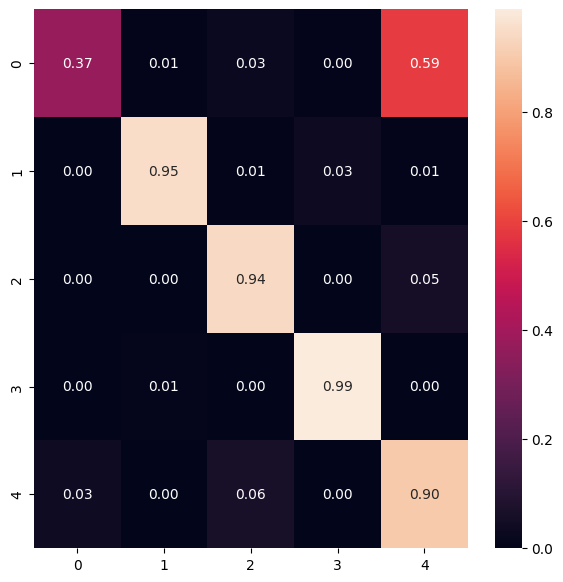

Accuracy: 0.8311111111111111
              precision    recall  f1-score   support

           0       0.91      0.37      0.53       403
           1       0.98      0.95      0.97       407
           2       0.90      0.94      0.92       404
           3       0.96      0.99      0.97       408
           4       0.58      0.90      0.71       403

    accuracy                           0.83      2025
   macro avg       0.87      0.83      0.82      2025
weighted avg       0.87      0.83      0.82      2025



In [12]:
# Calcular métricas
cm = confusion_matrix(original, predict)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(7, 7))
sns.heatmap(cm, annot=True, fmt=".2f")
plt.show()

accuracy = accuracy_score(original, predict)
report = classification_report(original, predict)
print(f'Accuracy: {accuracy}')
print(report)